# FASE 2: Voorspellen elektrisch verbruik warmtepomp

* kWh per tijdbasis 15m
* Household 1 gebruikt voor data (JVR)
* datetime features
   * stookseizoen
   * dag
   * uur

In [77]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

from scripts import weather_data_preprocess as wdp
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, LSTM, Dropout
from keras import models

## Data-analyse
### Inlezen en voorbereiden van data

In [78]:
# Open de datasets
df_heat = pd.read_csv('data/raw/household_1_heat_pump_consumption_warmtepomp from 2024-03-01.csv')
df_heat.head()

,_time,heat_consumption
0,2024-03-14 08:00:00+01:00,8017.324
1,2024-03-14 08:15:00+01:00,8017.365
2,2024-03-14 08:45:00+01:00,8017.488
3,2024-03-14 09:00:00+01:00,8017.525
4,2024-03-14 09:15:00+01:00,8017.561


In [79]:
# Kolommen hernoemen
df_heat.rename(columns={'_time': 'datetime', 'heat_consumption': 'consumption_kWh'}, inplace=True)

In [80]:
# Tijdskolom aanpassen
df_heat['datetime'] = (df_heat['datetime'].str.replace(' ', 'T'))
df_heat['datetime'] = (df_heat['datetime'].str.replace('+01:00', '', regex=False))
df_heat['datetime'] = (df_heat['datetime'].str.replace('+02:00', '', regex=False))
df_heat['datetime'] = pd.to_datetime(df_heat['datetime'], errors='coerce')
print(f"Errors: {df_heat['datetime'].isnull().sum()}")
df_heat = df_heat.dropna(subset=['datetime'])
print(f"Dataset size: {df_heat.size}")
df_heat.tail()

Errors: 0
Dataset size: 57092


,datetime,consumption_kWh
28541,2025-01-17 13:00:00.000000000,9447.173
28542,2025-01-17 13:15:00.000000000,9447.402
28543,2025-01-17 13:30:00.000000000,9447.618
28544,2025-01-17 13:45:00.000000000,9447.814
28545,2025-01-17 13:58:05.169652485,9447.985


In [81]:
# Eerste en laatste datetime vinden
first_date = df_heat['datetime'].min()
last_date = df_heat['datetime'].max()
print(f"First date: {first_date}, Last date: {last_date}")

First date: 2024-03-14 08:00:00, Last date: 2025-01-17 13:58:05.169652485


In [82]:
# Een nieuwe df aan maken met alle data tussen de eerste en laatste datum
df_range = pd.date_range(start=first_date, end=last_date, freq='15T')
df_heat_full = pd.DataFrame({'datetime': df_range})
df_heat_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29688 entries, 0 to 29687
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  29688 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 232.1 KB


In [83]:
# Meterstanden toevoegen aan de nieuwe df
df_heat_full = df_heat_full.merge(df_heat, on='datetime', how='left')
df_heat_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29692 entries, 0 to 29691
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         29692 non-null  datetime64[ns]
 1   consumption_kWh  28545 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 695.9 KB


In [84]:
# Analyse van de dataset
df_heat_full.head()

,datetime,consumption_kWh
0,2024-03-14 08:00:00,8017.324
1,2024-03-14 08:15:00,8017.365
2,2024-03-14 08:30:00,NaN
3,2024-03-14 08:45:00,8017.488
4,2024-03-14 09:00:00,8017.525


In [85]:
df_heat_full.tail()

,datetime,consumption_kWh
29687,2025-01-17 12:45:00,9446.932
29688,2025-01-17 13:00:00,9447.173
29689,2025-01-17 13:15:00,9447.402
29690,2025-01-17 13:30:00,9447.618
29691,2025-01-17 13:45:00,9447.814


In [86]:
df_heat_full.describe()

,consumption_kWh
count,28545.000000
mean,8534.105786
std,310.828906
min,8017.324000
25%,8338.288000
50%,8462.171000
75%,8635.691000
max,9447.814000


In [87]:
# Opvullen van missende waarden
df_heat_full = df_heat_full.sort_values(by='datetime')
df_heat_full['consumption_kWh'] = df_heat_full['consumption_kWh'].interpolate(method='linear')
df_heat_full = df_heat_full.reset_index(drop=True)
df_heat_full.head()

,datetime,consumption_kWh
0,2024-03-14 08:00:00,8017.3240
1,2024-03-14 08:15:00,8017.3650
2,2024-03-14 08:30:00,8017.4265
3,2024-03-14 08:45:00,8017.4880
4,2024-03-14 09:00:00,8017.5250


In [88]:
# Ruwe weersdata info
weather_data_ingelmunster = [
    'Ingelmunster 2024-03-01 to 2024-03-31.csv',
    'Ingelmunster 2024-04-01 to 2024-04-30.csv',
    'Ingelmunster 2024-05-01 to 2024-05-31.csv',
    'Ingelmunster 2024-06-01 to 2024-06-30.csv',
    'Ingelmunster 2024-07-01 to 2024-07-31.csv',
    'Ingelmunster 2024-08-01 to 2024-08-31.csv',
    'Ingelmunster 2024-09-01 to 2024-09-30.csv',
    'Ingelmunster 2024-10-01 to 2024-10-31.csv',
    'Ingelmunster 2024-11-01 to 2024-11-30.csv',
    'Ingelmunster 2024-12-01 to 2024-12-31.csv',
    'Ingelmunster 2025-01-01 to 2025-01-31.csv',
]
ingelmunster_location = [50.920699369528734, 3.2532075343447575]

In [89]:
# Interpoleren van de weergegevens
processor = wdp.WeatherDataPreprocess()
df_weather_ingelmunster = pd.DataFrame(columns=['datetime', 'temp', 'humidity', 'cloudcover', 'solarenergy', 'uvindex', 'latitude', 'longitude', 'solar_azimuth', 'solar_elevation'])
for file in range(len(weather_data_ingelmunster)):
    print(f'Processing {weather_data_ingelmunster[file]}')
    df_weather_ingelmunster = pd.concat([df_weather_ingelmunster, processor.preprocessWeatherData(lat=ingelmunster_location[0], lng=ingelmunster_location[1], file_name=weather_data_ingelmunster[file])])

Processing Ingelmunster 2024-03-01 to 2024-03-31.csv
Processing Ingelmunster 2024-04-01 to 2024-04-30.csv
Processing Ingelmunster 2024-05-01 to 2024-05-31.csv
Processing Ingelmunster 2024-06-01 to 2024-06-30.csv
Processing Ingelmunster 2024-07-01 to 2024-07-31.csv
Processing Ingelmunster 2024-08-01 to 2024-08-31.csv
Processing Ingelmunster 2024-09-01 to 2024-09-30.csv
Processing Ingelmunster 2024-10-01 to 2024-10-31.csv
Processing Ingelmunster 2024-11-01 to 2024-11-30.csv
Processing Ingelmunster 2024-12-01 to 2024-12-31.csv
Processing Ingelmunster 2025-01-01 to 2025-01-31.csv


In [90]:
# Verwijderen van de kolommen die niet nodig zijn
df_weather_ingelmunster.drop(columns=['humidity', 'latitude', 'longitude'], inplace=True)

In [91]:
# Datasets samenvoegen
df = pd.merge(df_heat_full, df_weather_ingelmunster, on='datetime', how='right')
df.head()

,datetime,consumption_kWh,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation
0,2024-03-01 00:00:00,NaN,10.00,94.100,0.0,0.0,-3.140464,-0.815327
1,2024-03-01 00:15:00,NaN,9.25,95.575,0.0,0.0,-3.045971,-0.813262
2,2024-03-01 00:30:00,NaN,8.50,97.050,0.0,0.0,-2.952222,-0.807331
3,2024-03-01 00:45:00,NaN,7.75,98.525,0.0,0.0,-2.859890,-0.797631
4,2024-03-01 01:00:00,NaN,7.00,100.000,0.0,0.0,-2.769568,-0.784312


In [92]:
df.tail()

,datetime,consumption_kWh,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation
32990,2025-01-31 22:00:00,NaN,3.50,0.0,0.0,0.0,2.327568,-0.848447
32991,2025-01-31 22:15:00,NaN,3.35,5.0,0.0,0.0,2.412971,-0.877163
32992,2025-01-31 22:30:00,NaN,3.20,10.0,0.0,0.0,2.503325,-0.903172
32993,2025-01-31 22:45:00,NaN,3.05,15.0,0.0,0.0,2.598675,-0.926103
32994,2025-01-31 23:00:00,NaN,2.90,20.0,0.0,0.0,2.698852,-0.945579


In [93]:
# kWh meterstand omrekenen naar kWh/kwartier
df['consumption_15kWh'] = (df['consumption_kWh'] - df['consumption_kWh'].shift(1))
df.drop(['consumption_kWh'], axis=1, inplace=True)
df.dropna(subset=['consumption_15kWh'], inplace=True)
df.head()

,datetime,temp,cloudcover,solarenergy,uvindex,solar_azimuth,solar_elevation,consumption_15kWh
1281,2024-03-14 08:15:00,8.325,54.475,0.325,0.5,-1.054120,0.330412,0.0410
1282,2024-03-14 08:30:00,8.750,50.350,0.450,1.0,-0.995562,0.365738,0.0615
1283,2024-03-14 08:45:00,9.175,46.225,0.575,1.5,-0.935324,0.399732,0.0615
1284,2024-03-14 09:00:00,9.600,42.100,0.700,2.0,-0.873267,0.432229,0.0370
1285,2024-03-14 09:15:00,10.000,48.875,0.900,2.5,-0.809274,0.463056,0.0360


In [94]:
# Eerste en laatste rijen verwijderen waar de meterstand niet klopt (0.0) doordat de meterstand niet is opgenomen
first_nonzero_idx = df[df['consumption_15kWh'] != 0.0].index[0]
last_nonzero_idx = df[df['consumption_15kWh'] != 0.0].index[-1]
df = df.loc[first_nonzero_idx:last_nonzero_idx].reset_index(drop=True)
print(f"Trimmed dataset between: {first_nonzero_idx} and {last_nonzero_idx}")

Trimmed dataset between: 1281 and 31613


In [95]:
def replace_outliers_with_mean(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mean_value = df[column].mean()
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = mean_value
    return df

df = replace_outliers_with_mean(df, 'consumption_15kWh')

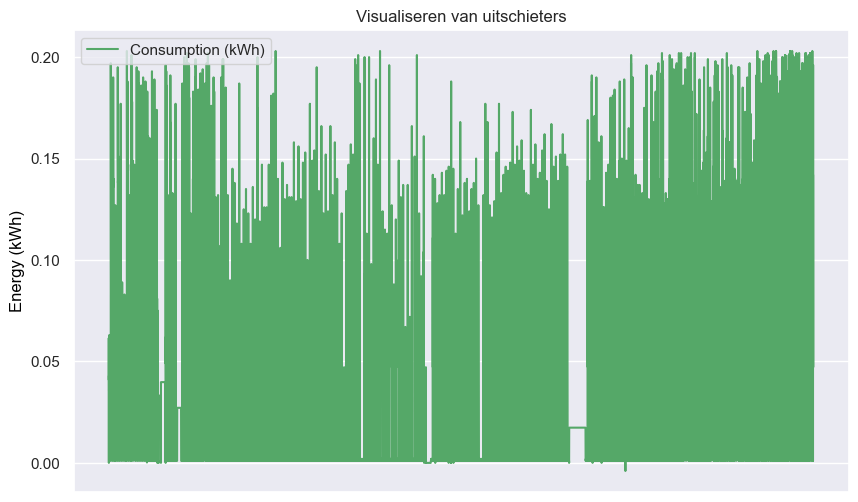

In [96]:
# Visualiseren van de uitschieters
plt.figure(figsize=(10, 6))
ax1 = plt.subplot()
plt.xticks(rotation=90)
ax1.plot(df['datetime'], df['consumption_15kWh'], label='Consumption (kWh)', color='g')
ax1.set_ylabel('Energy (kWh)', color='black')
ax1.legend(loc='upper left')
plt.xticks([])  # Removes the x-axis ticks
ax1.set_xticklabels([]) # Removes the x-axis labels
plt.title(f'Visualiseren van uitschieters')
plt.grid(True)
plt.show()

### Bewerking datetime en verwijderen van onnodige kolommen

In [97]:
# Geef de dag van het jaar, de dag van de week en de tijd van de dag weer als een sinus- en cosinusgolf
# Dag van het jaar extraheren
df['day_of_year'] = df['datetime'].dt.dayofyear
# Dag van de week extraheren
df['day_of_week'] = df['datetime'].dt.dayofweek
# Uur van de dag extraheren
df['time_of_day'] = df['datetime'].dt.hour
# Bereken sinus- en cosinuswaarden voor day_of_year
df['day_of_year_sine'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cosine'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
# Bereken sinus- en cosinuswaarden voor day_of_week
df['day_of_week_sine'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cosine'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
# Bereken sinus- en cosinuswaarden voor hour_of_day
df['hour_of_day_sine'] = np.sin(2 * np.pi * df['time_of_day'] / 24)
df['hour_of_day_cosine'] = np.cos(2 * np.pi * df['time_of_day'] / 24)

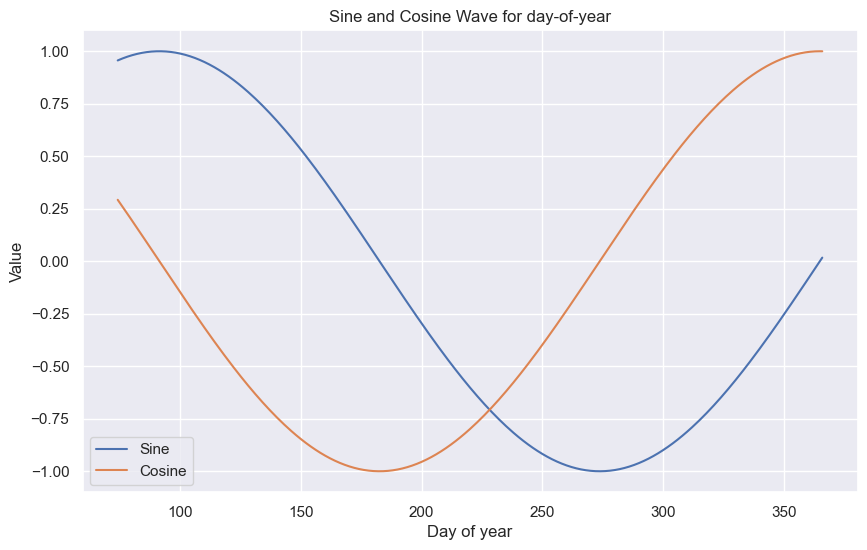

In [98]:
# day_of_year omvorming weergeven
df_single_year = df[df['datetime'].dt.year == 2024]
plt.figure(figsize=(10, 6))
plt.plot(df_single_year['day_of_year'], df_single_year['day_of_year_sine'], label='Sine')
plt.plot(df_single_year['day_of_year'], df_single_year['day_of_year_cosine'], label='Cosine')
plt.xlabel('Day of year')
plt.ylabel('Value')
plt.title('Sine and Cosine Wave for day-of-year')
plt.legend()
plt.grid(True)
plt.show()

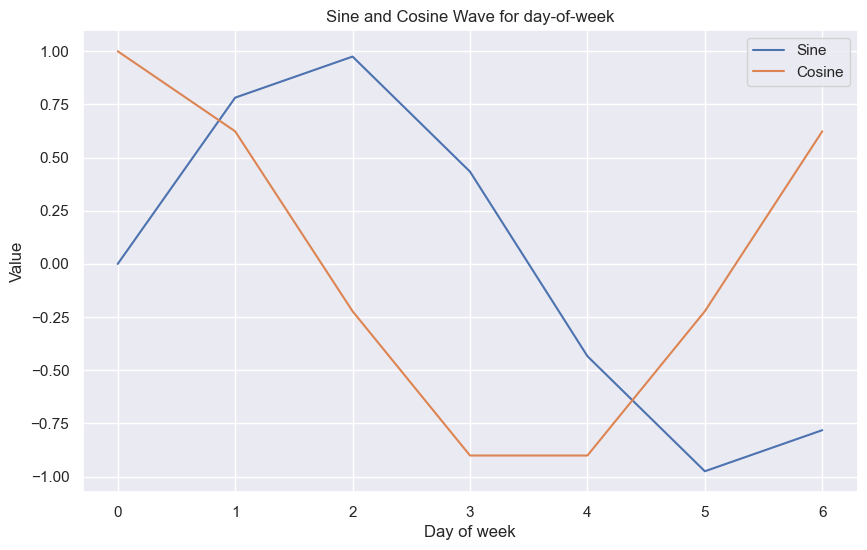

In [99]:
# day_of_week omvorming weergeven
df_single_month = df[df['datetime'].dt.day_of_year.isin([176, 177, 178, 179, 180, 181, 182])]
plt.figure(figsize=(10, 6))
plt.plot(df_single_month['day_of_week'], df_single_month['day_of_week_sine'], label='Sine')
plt.plot(df_single_month['day_of_week'], df_single_month['day_of_week_cosine'], label='Cosine')
plt.xlabel('Day of week')
plt.ylabel('Value')
plt.title('Sine and Cosine Wave for day-of-week')
plt.legend()
plt.grid(True)
plt.show()

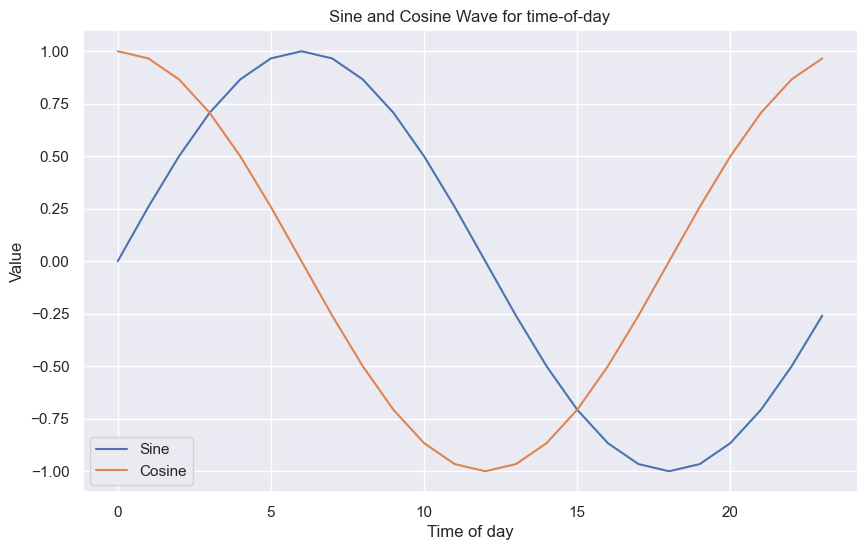

In [100]:
# hour_of_day omvorming weergeven 
df_single_day = df[df['datetime'].dt.day_of_year == 170]
plt.figure(figsize=(10, 6))
plt.plot(df_single_day['time_of_day'], df_single_day['hour_of_day_sine'], label='Sine')
plt.plot(df_single_day['time_of_day'], df_single_day['hour_of_day_cosine'], label='Cosine')
plt.xlabel('Time of day')
plt.ylabel('Value')
plt.title('Sine and Cosine Wave for time-of-day')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
# Verwijderen van overbodige kolommen
df.drop(columns=['day_of_year', 'day_of_week', 'time_of_day'], inplace=True)

Text(0.5, 1.0, 'Correlatiematrix')

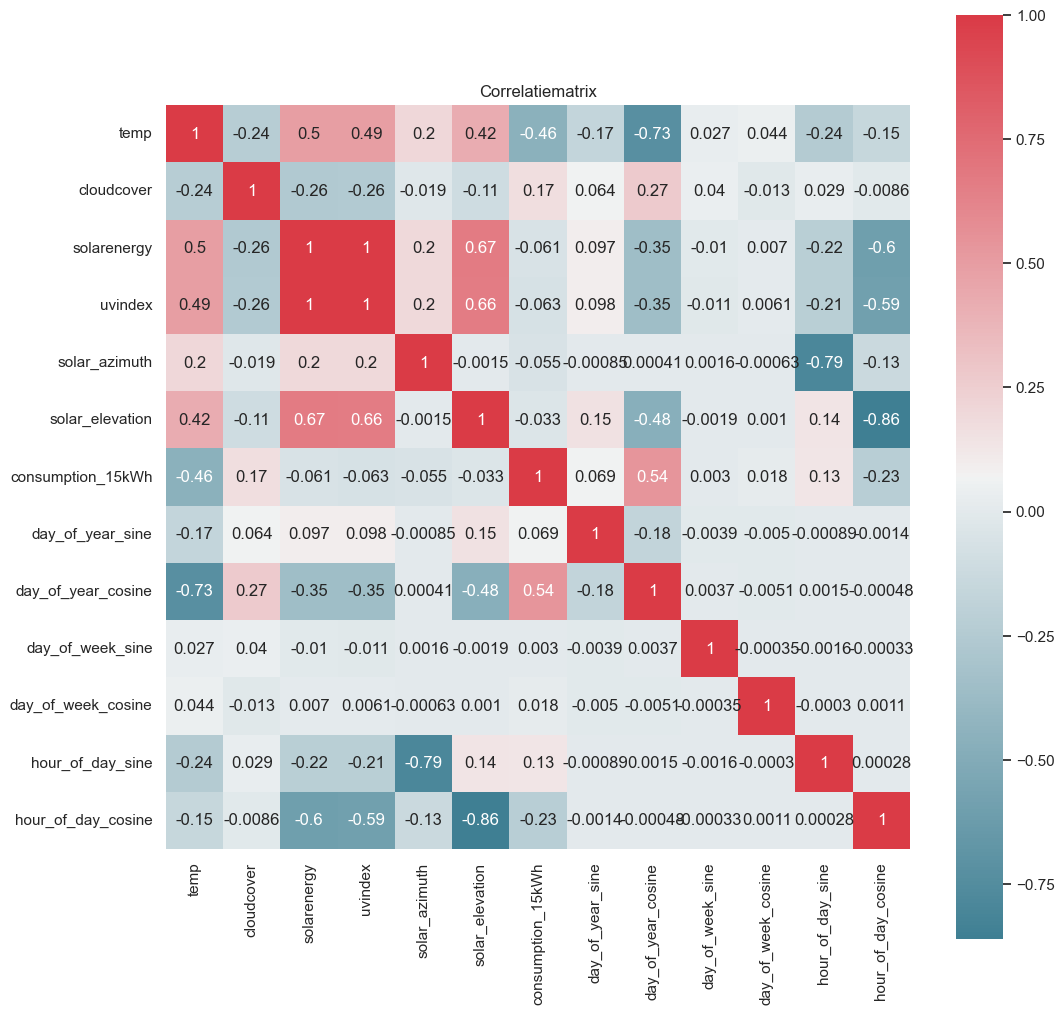

In [102]:
# Plotten van een heatmap om de correlatie tussen de features te visualiseren
f, ax = plt.subplots(figsize=(12, 12))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax, annot=True)
plt.title("Correlatiematrix")

## Pre-processing van de data

In [103]:
# Creëren van de train en test set dmv sequenties
def create_sequences(data, target, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i+n_steps_in])
        y.append(target[i+n_steps_in+n_steps_out-1 : i+n_steps_in+n_steps_out])
    return np.array(X), np.array(y)

df_train = df[df['datetime'].dt.year < 2025].drop(columns=['datetime'])
df_test = df[df['datetime'].dt.year == 2025].drop(columns=['datetime'])
df_train_target = df_train['consumption_15kWh'].values
df_test_target = df_test['consumption_15kWh'].values
#df_train_values = df_train.drop(columns=['consumption_15kWh']).values
#df_test_values = df_test.drop(columns=['consumption_15kWh']).values
df_train_values = df_train.values
df_test_values = df_test.values
X, y = create_sequences(df_train_values, df_train_target, n_steps_in=96, n_steps_out=8)
X_test, y_test = create_sequences(df_test_values, df_test_target, n_steps_in=96, n_steps_out=8)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X shape: (27969, 96, 13), y shape: (27969, 1)
X_test shape: (2158, 96, 13), y_test shape: (2158, 1)


In [104]:
# Shuffle de data
assert len(X) == len(y)

permutation = np.random.permutation(len(X))
X_shuffled = X[permutation]
y_shuffled = y[permutation]


lstm_scaler = MinMaxScaler()
X_shuffled = lstm_scaler.fit_transform(X_shuffled.reshape(-1, X_shuffled.shape[-1])).reshape(X_shuffled.shape)

assert not np.isnan(y_shuffled).any(), "NaNs in y"
assert not np.isinf(y_shuffled).any(), "Infs in y"

print(f"X: {X_shuffled.shape}, y: {y_shuffled.shape}")  # Should match (samples, timesteps, features)
print(f"y min/max: {y_shuffled.min()}, {y_shuffled.max()}")


X: (27969, 96, 13), y: (27969, 1)
y min/max: -0.003999999998995918, 0.20300000000133878


## Training

In [108]:
# LSTM model opzetten
LSTM_network_model_2_hour = Sequential()

LSTM_network_model_2_hour.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(96, 13)))
LSTM_network_model_2_hour.add(Dropout(0.2))
LSTM_network_model_2_hour.add(LSTM(64, activation='tanh'))
LSTM_network_model_2_hour.add(Dense(32, activation='relu'))
LSTM_network_model_2_hour.add(Dense(1, activation='linear'))

LSTM_network_model_2_hour.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
LSTM_network_model_2_hour.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 96, 128)           72704     
                                                                 
 dropout_3 (Dropout)         (None, 96, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 124225 (485.25 KB)
Trainable params: 124225 (485.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [109]:
# Een checkpoint aanmaken om het model op te slaan
checkpoint_name = 'wp_lstm_2_hours_ahead.keras' 
checkpoint = ModelCheckpoint(f'models/{checkpoint_name}', monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [110]:
# Trainen van het model
history_2_hours = LSTM_network_model_2_hour.fit(X_shuffled, y_shuffled, epochs=20, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/20
699/700 [============================>.] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1: val_loss improved from inf to 0.00105, saving model to models/wp_lstm_2_hours_ahead.keras
700/700 [==============================] - 53s 74ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 2/20
699/700 [============================>.] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 2: val_loss improved from 0.00105 to 0.00097, saving model to models/wp_lstm_2_hours_ahead.keras
700/700 [==============================] - 50s 71ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.6582e-04 - val_mean_squared_error: 9.6582e-04
Epoch 3/20
699/700 [============================>.] - ETA: 0s - loss: 9.7847e-04 - mean_squared_error: 9.7847e-04
Epoch 3: val_loss improved from 0.00097 to 0.00087, saving model to models/wp_lstm_2_hours_ahead.keras
700/700 [==============================] - 48s 68ms/ste

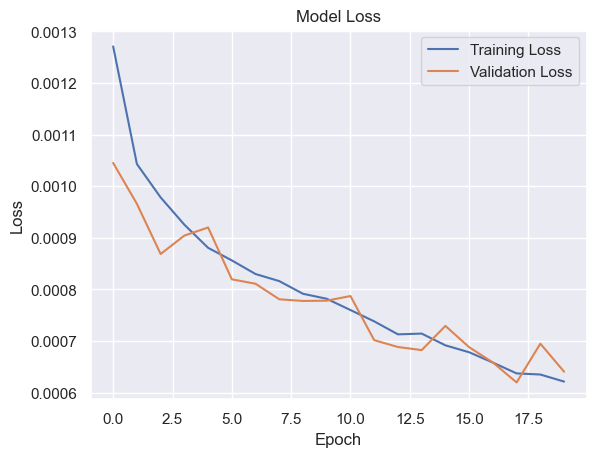

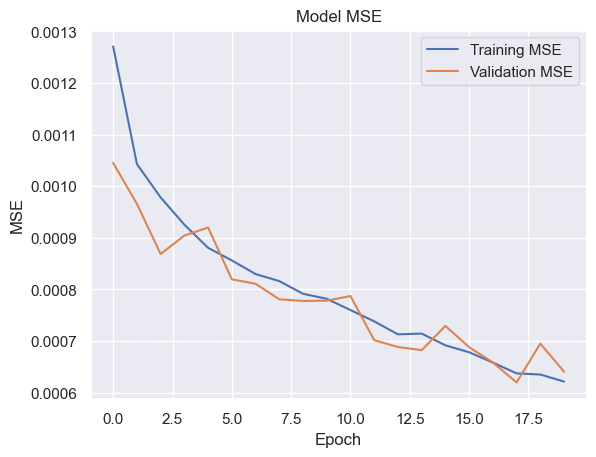

In [111]:
# Plot training and validation loss
plt.plot(history_2_hours.history['loss'], label='Training Loss')
plt.plot(history_2_hours.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(history_2_hours.history['mean_squared_error'], label='Training MSE')
plt.plot(history_2_hours.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Testen

In [112]:
best_model = models.load_model(f'models/{checkpoint_name}')

In [113]:
# Maak een voorspelling voor elke regel in de testdataset
X_test = lstm_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
df_result_lstm_2_hour = pd.DataFrame(y_test, columns=['consumption_15_min_%'])
df_result_lstm_2_hour['predicted_consumption_15_min_%'] = best_model.predict(X_test)
df_result_lstm_2_hour.head()

68/68 [==============================] - 2s 19ms/step


,consumption_15_min_%,predicted_consumption_15_min_%
0,0.139,0.094379
1,0.138,0.051568
2,0.139,0.088615
3,0.139,0.111315
4,0.137,0.129398


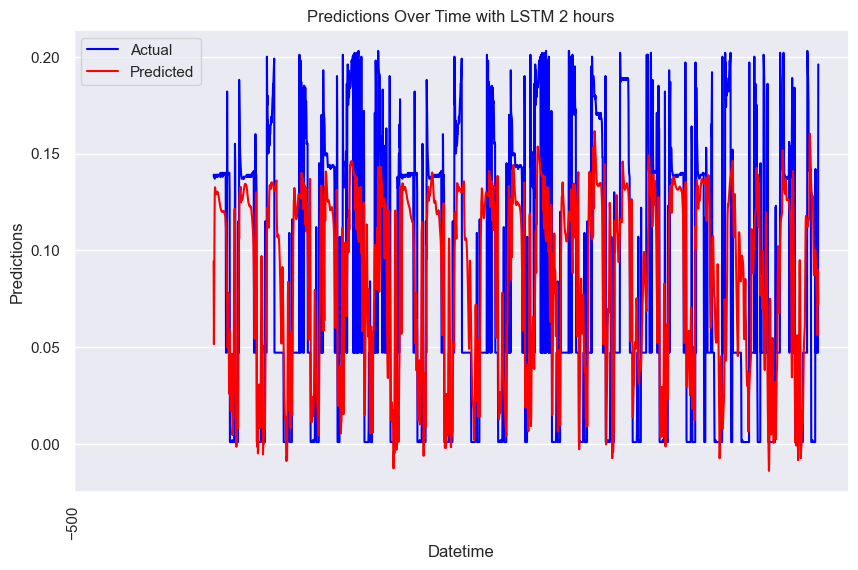

In [114]:
# Zet de voorspellingen uit in een grafiek LSTM 2h
plt.figure(figsize=(10, 6))
plt.plot(df_result_lstm_2_hour['consumption_15_min_%'], label='Actual', color='blue')
plt.plot(df_result_lstm_2_hour['predicted_consumption_15_min_%'], label='Predicted', color='red')
plt.xlabel('Datetime')
plt.ylabel('Predictions')
plt.title('Predictions Over Time with LSTM 2 hours')
plt.grid(True)
x_ticks = plt.gca().get_xticks()
x_ticks_selected = x_ticks[::24]
plt.xticks(x_ticks_selected, rotation=90)
plt.legend()
plt.show()

In [115]:
# Calculating the accuracy of each model based on the test data
print("### LSTM-model 2 hours ###")
print(f"mae: {mean_absolute_error(df_result_lstm_2_hour['consumption_15_min_%'], df_result_lstm_2_hour['predicted_consumption_15_min_%'])}")
print(f"mse: {mean_squared_error(df_result_lstm_2_hour['consumption_15_min_%'], df_result_lstm_2_hour['predicted_consumption_15_min_%'])}")
print(f"r2: {r2_score(df_result_lstm_2_hour['consumption_15_min_%'], df_result_lstm_2_hour['predicted_consumption_15_min_%'])}")

### LSTM-model 2 hours ###
mae: 0.04361052878359813
mse: 0.0029411358968259283
r2: 0.38171808233618953


Zonder consumptie van de voorbije 24 uur:

### LSTM-model 2 hours ###
mae: 0.050731033767122465
mse: 0.003607346458068737
r2: 0.24166812958915185

Met consumptie van de voorbije 24 uur:

### LSTM-model 2 hours ###
mae: 0.04361052878359813
mse: 0.0029411358968259283
r2: 0.38171808233618953